In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.util.shape import view_as_windows
from skimage.morphology import binary_erosion, binary_closing, binary_dilation

In [9]:
hr = cv.imread("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.0728/convolutions/synth_00005_pmc_0.0728.tif",cv.IMREAD_GRAYSCALE)
lr = cv.imread("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276/convolutions/synth_00005_pmc_0.3276.tif",cv.IMREAD_GRAYSCALE)
ulr = cv.imread("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276_linear/synth_00005_pmc_0.3276.png",cv.IMREAD_GRAYSCALE)
srcnn = cv.imread("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276_linear_SR/synth_00005_pmc_0.3276.png",cv.IMREAD_GRAYSCALE)
rcan = cv.imread("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/third_trial/omnipose_training/test/pmc_0.3276_linear_RCAN/synth_00005_pmc_0.3276.png",cv.IMREAD_GRAYSCALE)

In [10]:
hr.shape

(207, 54)

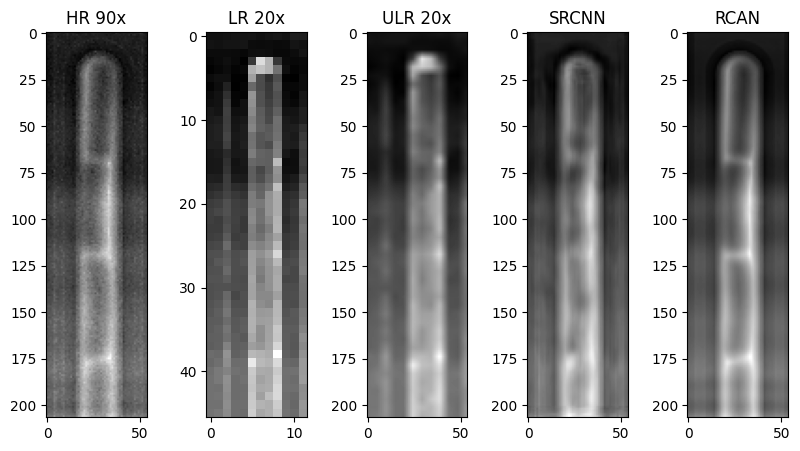

In [11]:
fig, axs = plt.subplots(1,5,figsize=[10,5])
axs[0].imshow(hr,'gray')
axs[0].set_title("HR 90x")
axs[1].imshow(lr,'gray')
axs[1].set_title("LR 20x")
axs[2].imshow(ulr,'gray')
axs[2].set_title("ULR 20x")
axs[3].imshow(srcnn,'gray')
axs[3].set_title("SRCNN")
axs[4].imshow(rcan,'gray')
axs[4].set_title("RCAN")
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/hrlrsrexamples.pdf")
plt.show()

In [4]:
img_path = "C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/superres/second_trial/SR_training/test/pmc_0.0655_cubic/synth_00000_pmc_0.0655.png"

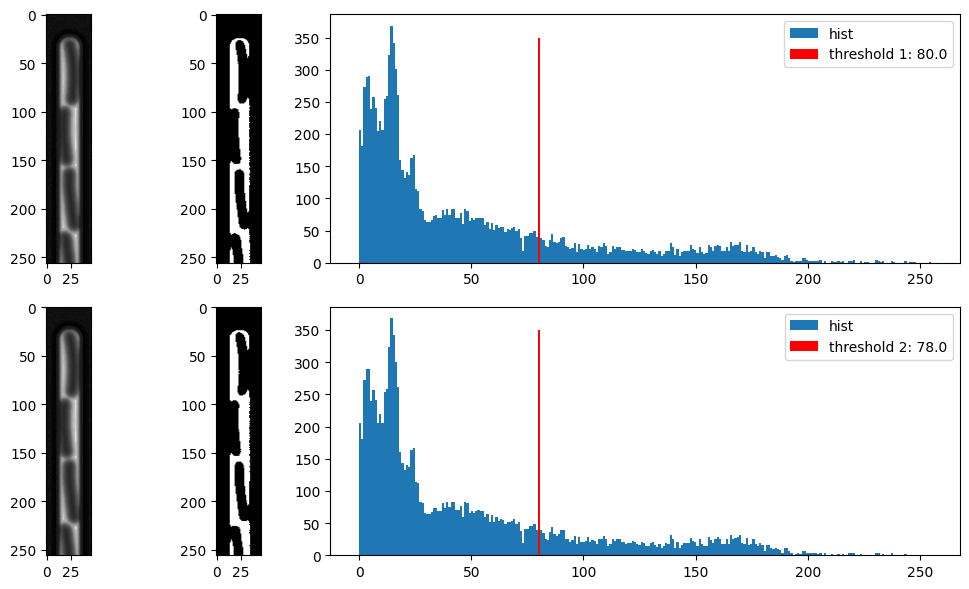

In [5]:
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
# global thresholding
# ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret1,th1 = cv.threshold(img,80,255,cv.THRESH_BINARY)


fig, axs = plt.subplots(2,3,figsize=[10,6],gridspec_kw={'width_ratios': [1, 1, 4]})
axs[0][0].imshow(img,'gray')
axs[0][1].imshow(th1,'gray')
axs[0][2].hist(img.ravel(),256,label="hist")
axs[0][2].hist([0]+[255]+[ret1]*350,256,color="red",label=f"threshold 1: {ret1}")
axs[0][2].legend()
axs[1][0].imshow(img,'gray')
axs[1][1].imshow(th2,'gray')
axs[1][2].hist(img.ravel(),256,label="hist")
axs[1][2].hist([0]+[255]+[80]*350,256,color="red",label=f"threshold 2: {ret2}")
axs[1][2].legend()
fig.tight_layout()
plt.show()

In [6]:
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
# find normalized_histogram, and its cumulative distribution function
hist = cv.calcHist([img],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
fn_list_list = []
v_list = []
for i in range(1,256):
    fn_list = []
    for j in range(1,i+1):
        fn_list.append(-1)
    for j in range(i+1,256):
        p1,p2,p3 = np.hsplit(hist_norm,[i,j]) # probabilities
        q1,q2,q3 = Q[i],Q[j]-Q[i],Q[255]-Q[j] # cum sum of classes
        b1,b2,b3 = np.hsplit(bins,[i,j]) # weights
        # finding means and variances
        m1,m2,m3 =  0 if q1 == 0 else np.sum(p1*b1)/q1, 0 if q2 == 0 else np.sum(p2*b2)/q2, 0 if q3 == 0 else np.sum(p3*b3)/q3
        v1,v2,v3 = 0 if q1 == 0 else np.sum(((b1-m1)**2)*p1)/q1, 0 if q2 == 0 else np.sum(((b2-m2)**2)*p2)/q2, 0 if q3 == 0 else np.sum(((b3-m3)**2)*p3)/q3
        # v_list.append([v1,v2])
        # calculates the minimization function
        fn = v1*q1 + v2*q2 + v3*q3
        fn_list.append(fn)
        if fn < fn_min:
            fn_min = fn
            thresh1 = i
            thresh2 = j
    fn_list_list.append(fn_list)

In [7]:
fn_array = np.array(fn_list_list)

In [8]:
fn_array[fn_array == -1] = np.max(fn_array)

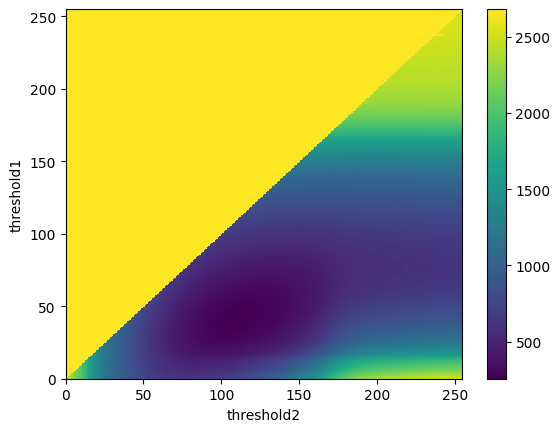

In [9]:
plt.pcolor(fn_array)
plt.ylabel("threshold1")
plt.xlabel("threshold2")
plt.colorbar()
plt.show()

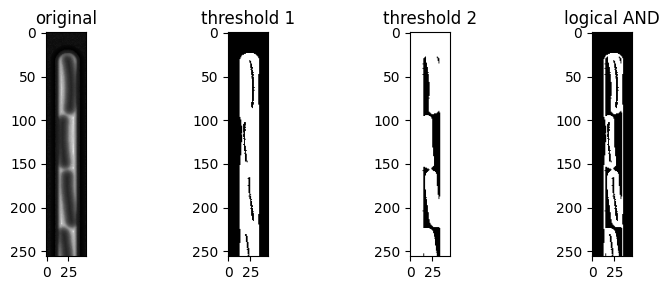

In [43]:
thresh1, thresh2 = 43, 111
# thresh1, thresh2 = 30, 100
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
# global thresholding
# ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
# Otsu's thresholding
ret1,th1 = cv.threshold(img,thresh1,255,cv.THRESH_BINARY)
ret2,th2 = cv.threshold(img,thresh2,255,cv.THRESH_BINARY_INV)
# th3 = np.logical_and(binary_dilation(binary_dilation(th1))*255==255,th2==255)
th3 = np.logical_and(th1==255,th2==255)

fig, axs = plt.subplots(1,4,figsize=[8,3],gridspec_kw={'width_ratios': [1,1,1,1]})
axs[0].imshow(img,'gray')
axs[0].set_title("original")
axs[1].imshow(th1,'gray')
axs[1].set_title("threshold 1")
axs[2].imshow(th2,'gray')
axs[2].set_title("threshold 2")
axs[3].imshow(th3,'gray')
axs[3].set_title("logical AND")
# axs[4].set_title("histogram of pixel intensities with thresholds")
# axs[4].hist(img.ravel(),256,label="hist")
# axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
# axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
# axs[4].legend()
fig.tight_layout()
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/otsu_pc_fig.pdf")
plt.show()

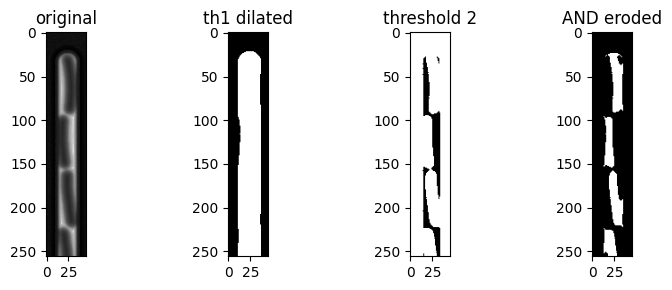

In [44]:
thresh1, thresh2 = 43, 111
# thresh1, thresh2 = 30, 100
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
# global thresholding
# ret1,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
# Otsu's thresholding
ret1,th1 = cv.threshold(img,thresh1,255,cv.THRESH_BINARY)
ret2,th2 = cv.threshold(img,thresh2,255,cv.THRESH_BINARY_INV)
th3 = np.logical_and(binary_dilation(binary_dilation(th1))*255==255,th2==255)
# th3 = np.logical_and(th1==255,th2==255)

fig, axs = plt.subplots(1,4,figsize=[8,3],gridspec_kw={'width_ratios': [1,1,1,1]})
axs[0].imshow(img,'gray')
axs[0].set_title("original")
axs[1].imshow(binary_dilation(binary_dilation(th1))*255,'gray')
axs[1].set_title("th1 dilated")
axs[2].imshow(th2,'gray') # binary_erosion(binary_erosion(th2))*255
axs[2].set_title("threshold 2")
axs[3].imshow(binary_erosion(binary_erosion(th3)),'gray')
axs[3].set_title("AND eroded")
# axs[4].set_title("histogram of pixel intensities with thresholds")
# axs[4].hist(img.ravel(),256,label="hist")
# axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
# axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
# axs[4].legend()
fig.tight_layout()
plt.savefig("C:/Users/robho/OneDrive/Desktop/Uni_Work/Year_4/project2/report_images/otsu_pc__morph_fig.pdf")
plt.show()

In [24]:
np.mean(binary_dilation(binary_dilation(th1))*255)

126.52556046195652

In [135]:
def adaptive(img_path,window_size,contrast_level):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    h,w = img.shape
    num_h = int(np.ceil(h/window_size))
    num_w = int(np.ceil(w/window_size))
    nh, nw = num_h*window_size, num_w*window_size
    padded_img = np.zeros([nh, nw])
    padded_img[nh-h:,:w] = img
    output_img = np.zeros([nh, nw])
    for i in range(num_h):
        for j in range(num_w):
            patch = padded_img[window_size*i:window_size*(i+1),window_size*j:window_size*(j+1)]
            Imin = np.min(patch)
            Imax = np.max(patch)
            if Imax - Imin < contrast_level:
                continue
            thresh = (Imax + Imin)/2
            output_patch = np.zeros([window_size, window_size])
            output_patch[patch >= thresh] = 255
            output_img[window_size*i:window_size*(i+1),window_size*j:window_size*(j+1)] = output_patch
    return output_img[nh-h:,:w]

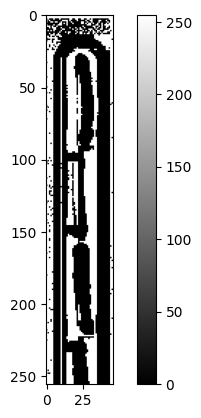

In [146]:
plt.imshow(adaptive(img_path,11,6),"gray")
plt.colorbar()
plt.show()

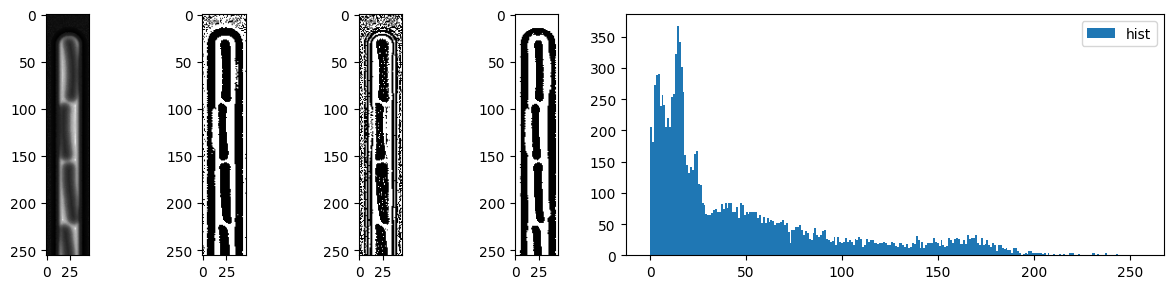

In [153]:
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
at1 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
at2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,1)
at3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,15,6)

fig, axs = plt.subplots(1,5,figsize=[12,3],gridspec_kw={'width_ratios': [1,1,1,1,4]})
axs[0].imshow(img,'gray')
axs[1].imshow(at1,'gray')
axs[2].imshow(at2,'gray')
axs[3].imshow(at3,'gray')
axs[4].hist(img.ravel(),256,label="hist")
# axs[4].hist([0]+[255]+[thresh1]*350,256,color="red",label=f"threshold 1: {thresh1}")
# axs[4].hist([0]+[255]+[thresh2]*350,256,color="purple",label=f"threshold 2: {thresh2}")
axs[4].legend()
fig.tight_layout()
plt.show()